In [1]:
# coding: UTF-8
import os
import torch
import numpy as np
import pickle as pkl
from tqdm import tqdm
import time
from datetime import timedelta
import time
import torch
import numpy as np
from train_eval import train, init_network
from importlib import import_module
import argparse
dataset = 'Newtrain_qinggan'  # 数据集

# 搜狗新闻:embedding_SougouNews.npz, 腾讯:embedding_Tencent.npz, 随机初始化:random
embedding = 'embedding_Newtrain_300.npz'

model_name = 'TextRCNN'  # 'TextRCNN'  # TextCNN, TextRNN, FastText, TextRCNN, TextRNN_Att, DPCNN, Transformer


x = import_module('models.' + model_name)
config = x.Config(dataset, embedding)
config.pad_size = 64

MAX_VOCAB_SIZE = 20000  # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，padding符号
ues_word = True
from utils import get_time_dif, build_vocab, build_dataset2, build_iterator2


vocab, train, test = build_dataset2(config, ues_word)

Vocab size: 12678


8000it [00:00, 65309.71it/s]
2653it [00:00, 67107.45it/s]


In [2]:
import torch.nn.functional as F


train_iter = build_iterator2(train, config)
test_iter = build_iterator2(test, config)
# train_iter.__next__()
config.n_vocab = len(vocab)
model = x.Model(config).to(config.device)
if model_name != 'Transformer':
    init_network(model)
print(model.parameters)

<bound method Module.parameters of Model(
  (embedding): Embedding(12678, 300)
  (lstm): LSTM(300, 256, batch_first=True, dropout=1.0, bidirectional=True)
  (maxpool): MaxPool1d(kernel_size=64, stride=64, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=812, out_features=3, bias=True)
)>


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.0 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
import numpy as np
import torch
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time
from collections import defaultdict
from utils import get_time_dif
from tensorboardX import SummaryWriter
from train_eval import train_qinggan

train_qinggan(config, model, train_iter, test_iter)

Epoch [1/10]
Iter:      0,  Train Loss:   1.0,  Train Acc: 17.19%,  Val Loss:  0.57,  Val Acc: 67.73%,  Time: 0:10:27 *improve


In [13]:
import json

with open(config.log_path + '/train_dict.json', 'r', encoding='utf-8') as file:
    train_dict = json.load(file)
with open(config.log_path + '/test_dict.json', 'r', encoding='utf-8') as file:
    test_dict = json.load(file)


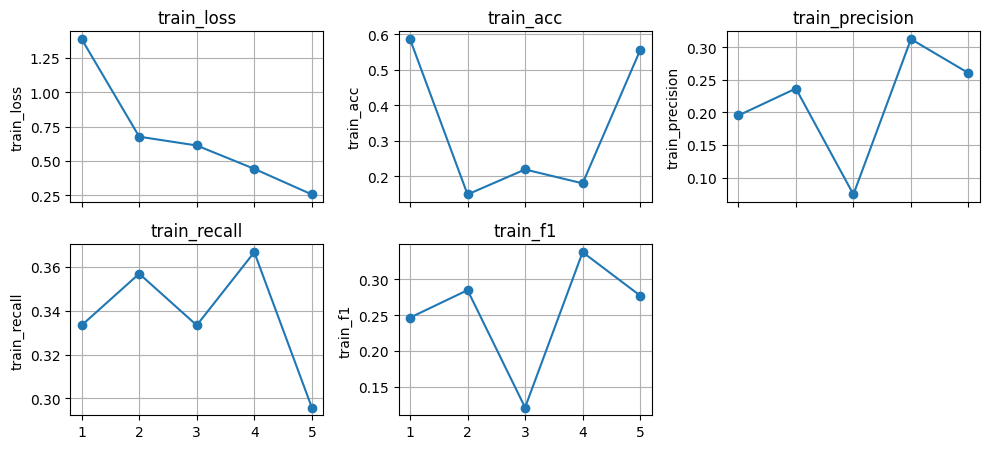

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_dict['train_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(train_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(train_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()

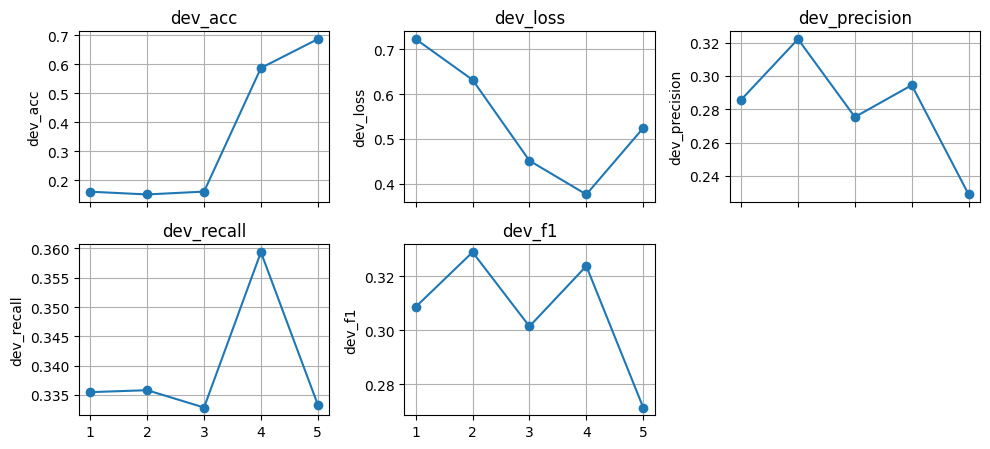

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_dict['dev_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(test_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(test_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters,lr=config.learning_rate,eps=1e-8)

# 学习率指数衰减，每次epoch：学习率 = gamma * 学习率
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = len(train_iter) * config.num_epochs)
